# Data download and preparation


- I downloaded the data from kaggle: https://www.kaggle.com/competitions/asap-aes/data
- Usually one can download from kaggle with code, but due to the set of terms and conditions, I found point-and-click to be much more straightforward
- I downloaded `asap-aes.zip` into `data/0_raw/` and unzipped
- Everything after that follows from this
- This notebook takes the unzipped data and creates a training/test/validation split (the original data had a different split, but I was not able to obtain targets for those data)


In [1]:
import numpy as np
import polars as pl

In [4]:

!pip install fastexcel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.4 MB/s eta 0:00:00a 0:00:01


In [5]:
df = pl.read_excel('../data/0_raw/training_set_rel3.xlsx').filter(pl.col('domain1_score').is_not_null())

df = df.select([
    pl.col('essay_id').alias('id'),
    pl.col('essay').alias('text'),
    pl.col('domain1_score').alias('score')
])


In [6]:
np.random.seed(42)  # For reproducibility
assignments = np.random.choice([1, 2, 3], size=len(df), p=[0.8, 0.15, 0.05])
df = df.with_columns(pl.Series(assignments).alias('assign'))

# Split the dataframe based on 'assign'
training = df.filter(pl.col('assign') == 1)
testing = df.filter(pl.col('assign') == 2)
val = df.filter(pl.col('assign') == 3)

In [7]:
training.write_csv('../data/1_clean/training.csv')
testing.write_csv('../data/1_clean/testing.csv')
val.write_csv('../data/1_clean/val.csv')

# We can also do some preliminary data investigation while we are here

In [8]:
print(f"{training.shape=}, {testing.shape=}, {val.shape=}")

training.shape=(10403, 4), testing.shape=(1952, 4), val.shape=(622, 4)


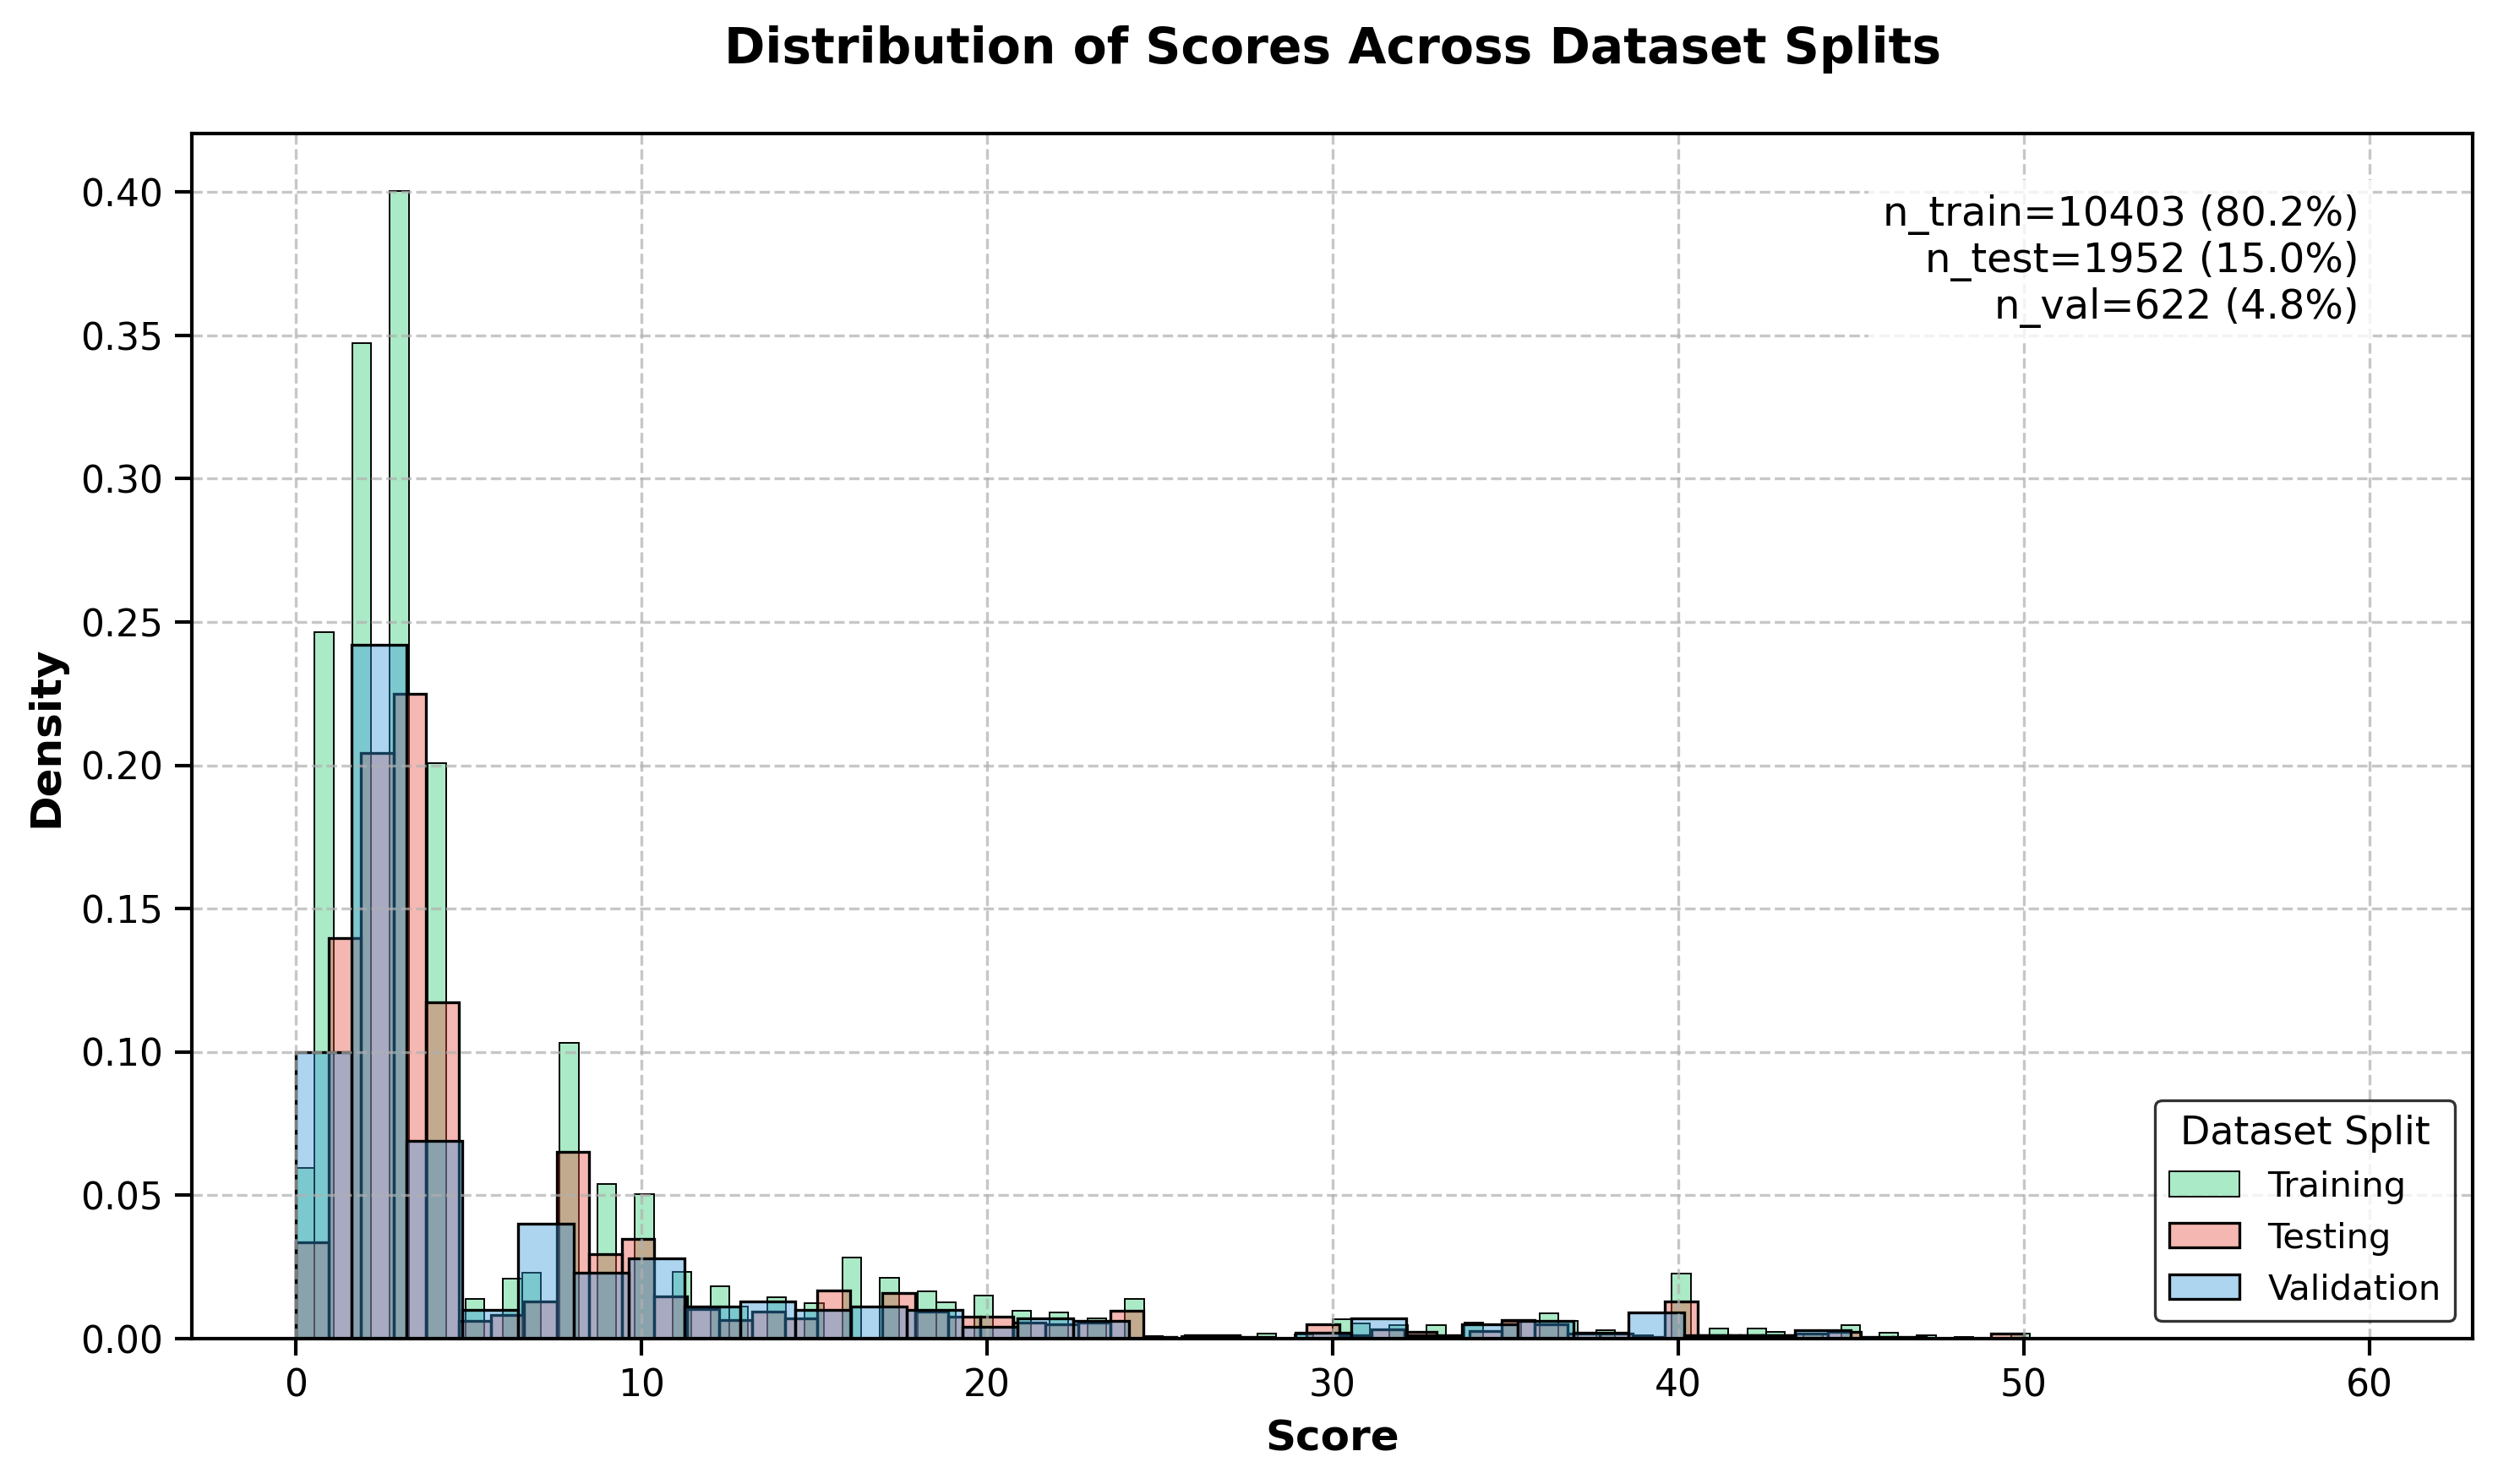

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for publication quality
# plt.style.use('seaborn-paper')
sns.set_context("paper", font_scale=1.2)

# Create the figure and axis with a specific size for publication
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot histograms with density normalization and transparency
sns.histplot(data=training['score'],
            stat='density',
            alpha=0.4,
            label='Training',
            color='#2ecc71',
            ax=ax)

sns.histplot(data=testing['score'],
            stat='density',
            alpha=0.4,
            label='Testing',
            color='#e74c3c',
            ax=ax)

sns.histplot(data=val['score'],
            stat='density',
            alpha=0.4,
            label='Validation',
            color='#3498db',
            ax=ax)

# Customize the plot
ax.set_xlabel('Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Scores Across Dataset Splits',
             fontsize=14,
             fontweight='bold',
             pad=20)

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Customize legend
ax.legend(title='Dataset Split',
         title_fontsize=11,
         fontsize=10,
         frameon=True,
         fancybox=True,
         framealpha=0.8,
         edgecolor='black')

# Add text with dataset sizes
total = len(training) + len(testing) + len(val)
text = (f'n_train={len(training)} ({len(training)/total:.1%})\n'
        f'n_test={len(testing)} ({len(testing)/total:.1%})\n'
        f'n_val={len(val)} ({len(val)/total:.1%})')

plt.text(0.95, 0.95, text,
         transform=ax.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Save the figure with high quality
plt.savefig('../outputs/graphics/0_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()